In [1]:
# Install if needed (uncomment in Colab/Jupyter)
# !pip install pandas numpy matplotlib seaborn scikit-learn plotly

# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing & pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize


In [2]:
# Load dataset
df = pd.read_csv("data.csv")

# Quick look at dataset
print("Shape:", df.shape)
print(df.head())

# Automatically pick target column
target_col = df.columns[-1]
print("Target Column:", target_col)


Shape: (569, 32)
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimete

In [3]:
#  Handle Duplicates
print("Before removing duplicates:", df.shape)
df.drop_duplicates(inplace=True)
print("After removing duplicates:", df.shape)

Before removing duplicates: (569, 32)
After removing duplicates: (569, 32)


In [4]:
#  Handle Missing Values Check
print("\nMissing values per column:")
print(df.isnull().sum())



Missing values per column:
id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

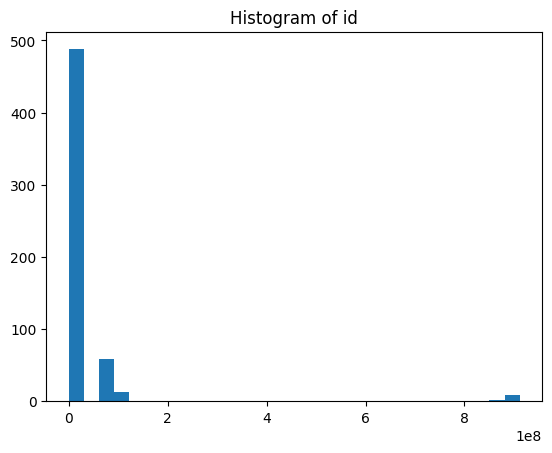

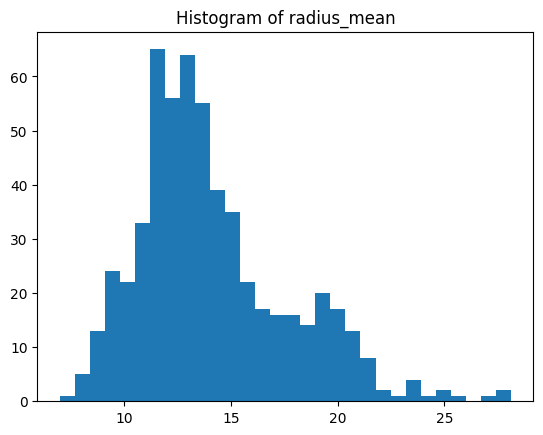

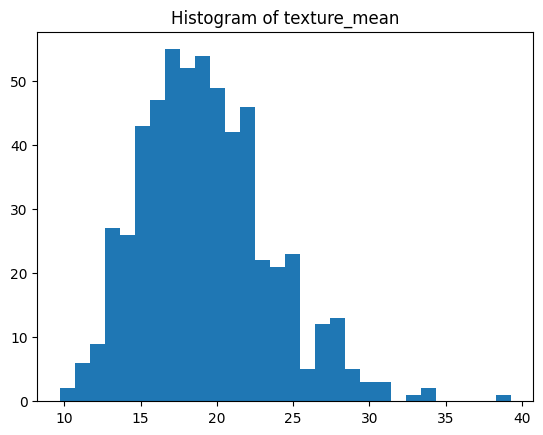

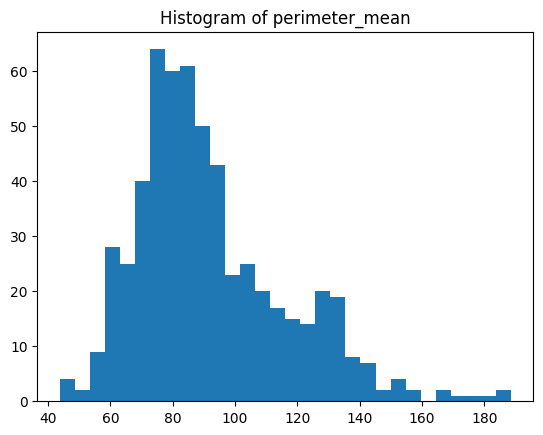

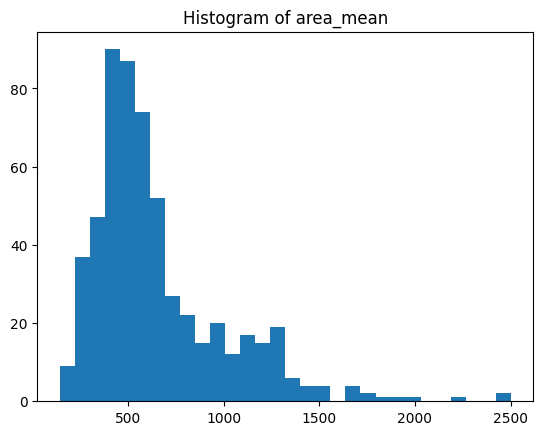

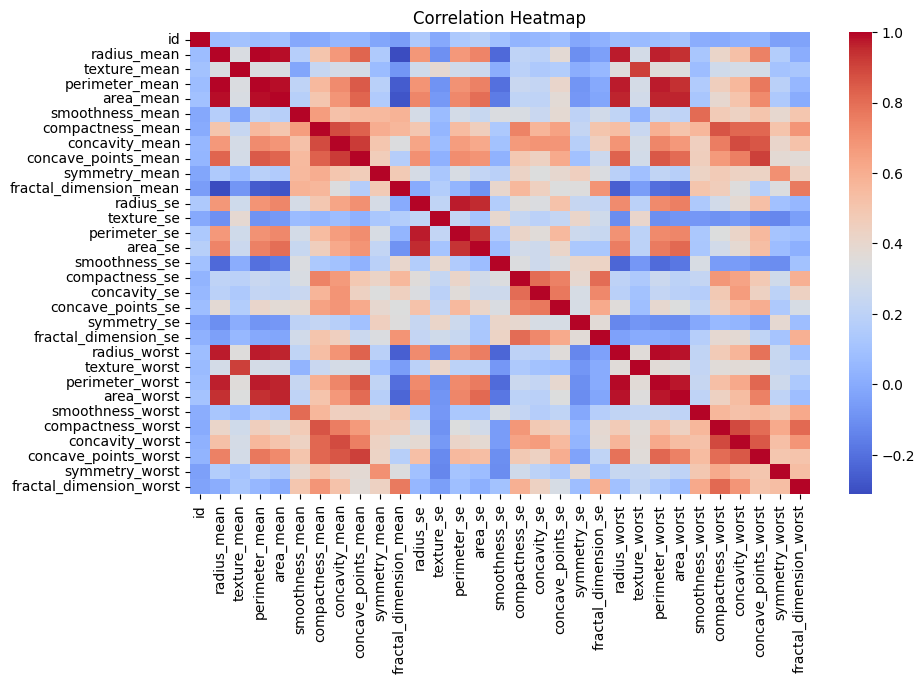

In [5]:
# Dataset info
df.info()
df.describe(include="all")

# Class distribution (if categorical target)
if df[target_col].nunique() <= 30:
    df[target_col].value_counts().plot(kind="bar", title="Class Distribution")
    plt.show()

# Numeric histograms
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols[:5]:
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histogram of {col}")
    plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols].corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

# interactive scatter (only works in notebook, not .py)
if len(numeric_cols) >= 2:
    fig = px.scatter(df, x=numeric_cols[0], y=numeric_cols[1], color=target_col)
    fig.show()


In [6]:
# Split X and y
X = df.drop(columns=[target_col])
y = df[target_col]

# Separate numeric and categorical features
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Define transformers
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
    stratify=y if y.nunique() <= 30 else None
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (455, 31)
Test shape: (114, 31)


In [7]:
#  Force classification (if target is continuous)
# If target has too many unique values, bin them into categories
if y.nunique() > 30:
    print("Target seems continuous, converting into categories for classifiers...")

    y = pd.qcut(y, q=3, labels=["Low", "Medium", "High"])


Target seems continuous, converting into categories for classifiers...


In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
    stratify=y if y.nunique() <= 30 else None
)


In [9]:
#  Detect task type (classification vs regression) ----
if y.nunique() <= 30:  # assume classification if <=30 unique labels
    task_type = "classification"
    y_train = y_train.astype(str)
    y_test = y_test.astype(str)
else:
    task_type = "regression"

print("Detected task type:", task_type)


Detected task type: classification


In [10]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

if task_type == "classification":
    models = {
        "KNN": Pipeline([("preprocess", preprocessor), ("model", KNeighborsClassifier())]),
        "DecisionTree": Pipeline([("preprocess", preprocessor), ("model", DecisionTreeClassifier(random_state=42))]),
        "RandomForest": Pipeline([("preprocess", preprocessor), ("model", RandomForestClassifier(random_state=42))]),
    }
else:  # regression
    models = {
        "KNN": Pipeline([("preprocess", preprocessor), ("model", KNeighborsRegressor())]),
        "DecisionTree": Pipeline([("preprocess", preprocessor), ("model", DecisionTreeRegressor(random_state=42))]),
        "RandomForest": Pipeline([("preprocess", preprocessor), ("model", RandomForestRegressor(random_state=42))]),
    }


In [11]:
baseline_results = []

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    if task_type == "classification":
        acc = accuracy_score(y_test, preds)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, preds, average="weighted", zero_division=0
        )
        baseline_results.append([name, acc, precision, recall, f1])
        print(f"\n{name} Classification Report:\n", classification_report(y_test, preds))

    else:  # regression
        from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)
        baseline_results.append([name, mae, rmse, r2])
        print(f"\n{name} Regression Results:\n MAE={mae:.3f}, RMSE={rmse:.3f}, R²={r2:.3f}")



KNN Classification Report:
               precision    recall  f1-score   support

        High       0.79      0.79      0.79        38
         Low       0.72      0.82      0.77        38
      Medium       0.61      0.53      0.56        38

    accuracy                           0.71       114
   macro avg       0.71      0.71      0.71       114
weighted avg       0.71      0.71      0.71       114


DecisionTree Classification Report:
               precision    recall  f1-score   support

        High       0.85      0.74      0.79        38
         Low       0.78      0.82      0.79        38
      Medium       0.63      0.68      0.66        38

    accuracy                           0.75       114
   macro avg       0.75      0.75      0.75       114
weighted avg       0.75      0.75      0.75       114


RandomForest Classification Report:
               precision    recall  f1-score   support

        High       0.81      0.79      0.80        38
         Low       0.83 

In [12]:
if task_type == "classification":
    baseline_df = pd.DataFrame(baseline_results, columns=["Model","Accuracy","Precision","Recall","F1"])
else:
    baseline_df = pd.DataFrame(baseline_results, columns=["Model","MAE","RMSE","R2"])


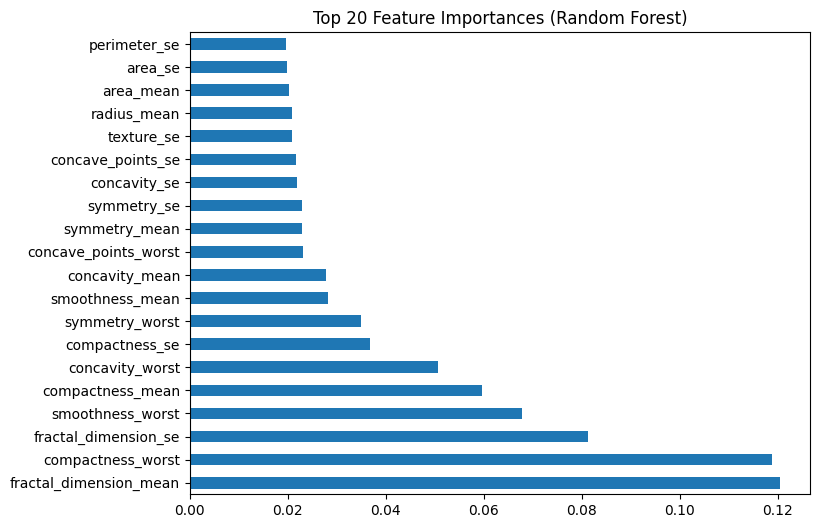

In [13]:
rf_pipe = models["RandomForest"]
rf_pipe.fit(X_train, y_train)

# Extract feature names
fitted_pre = rf_pipe.named_steps["preprocess"]
num_features = numeric_cols
cat_features = fitted_pre.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(categorical_cols).tolist()
feature_names = num_features + cat_features

# Feature importances
importances = rf_pipe.named_steps["model"].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot
feat_imp[:20].plot(kind="barh", figsize=(8,6))
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()


In [14]:
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, mean_absolute_error, mean_squared_error, r2_score
)


# Detect task type

if y.nunique() <= 30:  # assume classification if <=30 unique labels
    task_type = "classification"
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scoring = "accuracy"
else:
    task_type = "regression"
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = "r2"

print("Detected task type:", task_type)

# Define param grids

knn_params = {"model__n_neighbors": range(1, 30), "model__weights": ["uniform","distance"]}
dt_params  = {"model__max_depth": [None]+list(range(2,20)), "model__min_samples_split": range(2,10)}
rf_params  = {"model__n_estimators": range(50,200), "model__max_depth":[None,5,10,20], "model__min_samples_split": range(2,10)}


# Run RandomizedSearchCV

knn_search = RandomizedSearchCV(models["KNN"], knn_params, n_iter=20, cv=cv, scoring=scoring, random_state=42, n_jobs=-1)
dt_search  = RandomizedSearchCV(models["DecisionTree"], dt_params, n_iter=20, cv=cv, scoring=scoring, random_state=42, n_jobs=-1)
rf_search  = RandomizedSearchCV(models["RandomForest"], rf_params, n_iter=20, cv=cv, scoring=scoring, random_state=42, n_jobs=-1)

searches = {
    "KNN_tuned": knn_search,
    "DecisionTree_tuned": dt_search,
    "RandomForest_tuned": rf_search
}

# Collect results

tuned_results = []

for name, search in searches.items():
    search.fit(X_train, y_train)
    preds = search.best_estimator_.predict(X_test)

    if task_type == "classification":
        acc = accuracy_score(y_test, preds)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average="weighted", zero_division=0)
        tuned_results.append([name, acc, precision, recall, f1])
        print(f"\n{name} Best Params:", search.best_params_)
        print(f"{name} Classification Report:\n", classification_report(y_test, preds))

    else:
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)
        tuned_results.append([name, mae, rmse, r2])
        print(f"\n{name} Best Params:", search.best_params_)
        print(f"{name} Regression Results: MAE={mae:.3f}, RMSE={rmse:.3f}, R²={r2:.3f}")


# Put results in DataFrame

if task_type == "classification":
    tuned_df = pd.DataFrame(tuned_results, columns=["Model","Accuracy","Precision","Recall","F1"])
else:
    tuned_df = pd.DataFrame(tuned_results, columns=["Model","MAE","RMSE","R2"])

print("\nTuned Results:\n", tuned_df)


Detected task type: classification

KNN_tuned Best Params: {'model__weights': 'distance', 'model__n_neighbors': 9}
KNN_tuned Classification Report:
               precision    recall  f1-score   support

        High       0.72      0.68      0.70        38
         Low       0.73      0.71      0.72        38
      Medium       0.46      0.50      0.48        38

    accuracy                           0.63       114
   macro avg       0.64      0.63      0.63       114
weighted avg       0.64      0.63      0.63       114


DecisionTree_tuned Best Params: {'model__min_samples_split': 4, 'model__max_depth': 3}
DecisionTree_tuned Classification Report:
               precision    recall  f1-score   support

        High       0.81      0.79      0.80        38
         Low       0.77      0.79      0.78        38
      Medium       0.61      0.61      0.61        38

    accuracy                           0.73       114
   macro avg       0.73      0.73      0.73       114
weighted avg 


Combined Results:
                 Model  Accuracy  Precision    Recall        F1   Version
0                 KNN  0.710526   0.705488  0.710526  0.706095  Baseline
1        DecisionTree  0.745614   0.752544  0.745614  0.747277  Baseline
2        RandomForest  0.780702   0.778175  0.780702  0.778812  Baseline
0           KNN_tuned  0.631579   0.638456  0.631579  0.634572     Tuned
1  DecisionTree_tuned  0.728070   0.728435  0.728070  0.728161     Tuned
2  RandomForest_tuned  0.771930   0.772792  0.771930  0.772084     Tuned

Best Model: RandomForest

Final Classification Report:
               precision    recall  f1-score   support

        High       0.81      0.79      0.80        38
         Low       0.83      0.89      0.86        38
      Medium       0.69      0.66      0.68        38

    accuracy                           0.78       114
   macro avg       0.78      0.78      0.78       114
weighted avg       0.78      0.78      0.78       114



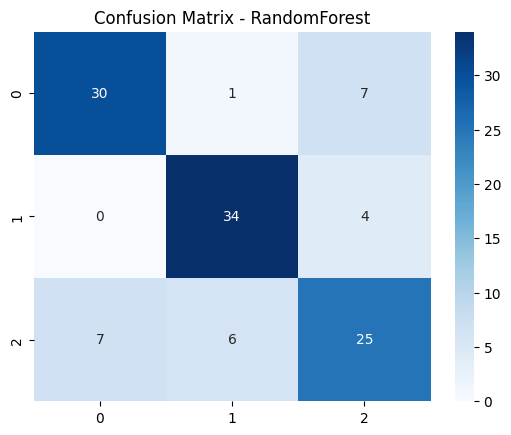

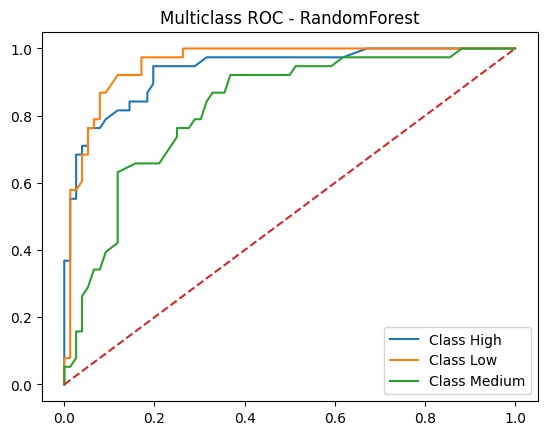

In [15]:
# Combine results
combined_df = pd.concat([
    baseline_df.assign(Version="Baseline"),
    tuned_df.assign(Version="Tuned")
])

print("\nCombined Results:\n", combined_df)

# Select best model depending on task type

if task_type == "classification":
    best_model = combined_df.sort_values(by=["Accuracy","F1"], ascending=False).iloc[0]["Model"]
else:  # regression
    best_model = combined_df.sort_values(by=["R2","MAE"], ascending=[False, True]).iloc[0]["Model"]

print("\nBest Model:", best_model)

# Retrieve the actual estimator

if best_model.endswith("_tuned"):
    est = searches[best_model].best_estimator_
else:
    est = models[best_model]


# Final Evaluation

preds = est.predict(X_test)

if task_type == "classification":
    print("\nFinal Classification Report:\n", classification_report(y_test, preds))

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {best_model}")
    plt.show()

    # ROC Curve (binary or multiclass)
    classes = np.unique(y)
    if hasattr(est, "predict_proba"):
        if len(classes) == 2:
            proba = est.predict_proba(X_test)[:,1]
            fpr, tpr, _ = roc_curve((y_test == classes[1]).astype(int), proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
            plt.plot([0,1],[0,1],"--")
            plt.legend(); plt.title(f"ROC Curve - {best_model}")
            plt.show()
        else:
            y_bin = label_binarize(y_test, classes=classes)
            proba = est.predict_proba(X_test)
            for i in range(len(classes)):
                fpr, tpr, _ = roc_curve(y_bin[:,i], proba[:,i])
                plt.plot(fpr, tpr, label=f"Class {classes[i]}")
            plt.plot([0,1],[0,1],"--")
            plt.legend(); plt.title(f"Multiclass ROC - {best_model}")
            plt.show()

else:  # regression
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"\nFinal Regression Results:\n MAE={mae:.3f}, RMSE={rmse:.3f}, R²={r2:.3f}")

    # Plot predictions vs true
    plt.scatter(y_test, preds, alpha=0.6)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title(f"Predicted vs Actual - {best_model}")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.show()


In [16]:
# Summary of Baseline Models
print("\nBaseline Model Comparison:")
print(baseline_df)

#  Summary of Tuned Models
print("\nTuned Model Comparison:")
print(tuned_df)



Baseline Model Comparison:
          Model  Accuracy  Precision    Recall        F1
0           KNN  0.710526   0.705488  0.710526  0.706095
1  DecisionTree  0.745614   0.752544  0.745614  0.747277
2  RandomForest  0.780702   0.778175  0.780702  0.778812

Tuned Model Comparison:
                Model  Accuracy  Precision    Recall        F1
0           KNN_tuned  0.631579   0.638456  0.631579  0.634572
1  DecisionTree_tuned  0.728070   0.728435  0.728070  0.728161
2  RandomForest_tuned  0.771930   0.772792  0.771930  0.772084
